# Harmonic Analysis of the Red Llama Overdrive
**Author:** Jackson Ferguson  
**Data Source:** Custom RP2040 DAQ (Burst Mode)  
**Objective:** To empirically characterize the saturation topology and harmonic fingerprint of the CMOS Hex Inverter, validating the "Tube-like" asymmetry hypothesis via time-domain correlation and spectral analysis.

**Key Libraries:** `numpy`, `scipy`, `matplotlib`, `seaborn`, `pandas`, `src` (Local)

# 1. Environment Setup & Library Import
We begin by initializing the Python environment and importing the custom `src` library. 
This notebook relies on the following modules:
* `src.io`: Handles `.npz` data ingestion and metadata scanning.
* `src.dsp`: Provides signal processing algorithms (FFT, THD, Phase Alignment).
* `src.analysis`: Contains the visualization logic for generating publication-ready plots.

In [ ]:
import os

import numpy as np
import seaborn as sns
from sysaudio import config, dsp, io, plots

# Define Paths
# Current: .../oscilloscope-rp2040/notebooks
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
repo_root = os.path.abspath(os.path.join(project_root, ".."))

# Figures Directory: .../docs/figures
FIGURES_DIR = os.path.join(repo_root, "docs", "figures")

# Ensure it exists
os.makedirs(FIGURES_DIR, exist_ok=True)

# Set Styling
sns.set_style("darkgrid")
print(f"📂 Figures will be saved to: {os.path.relpath(FIGURES_DIR, repo_root)}")

📂 Figures will be saved to: docs/figures


# 2. Data Inventory
We scan the `data/burst/` directory to identify available capture files. 
The metadata (Sampling Rate, Peak Voltage, Dominant Frequency) is extracted from the `.npz` headers to verify that our datasets are valid before loading.

In [2]:
df = io.scan_metadata(config.DATA_DIR_BURST)

if not df.empty:
    cols = (
        ["filename"]
        + [c for c in df.columns if c not in ["filename", "user_notes"]]
        + ["user_notes"]
    )
    cols = [c for c in cols if c in df.columns]
    print(f"Found {len(df)} data files\n")
    print(df[cols].to_string(index=False))
else:
    print("⚠️  No .npz files found!")

Found 22 data files

                                   filename    fs                  timestamp  v_ref  adc_bits    v_min    v_max  dc_offset clipped peak_voltage dominant_freq audio_type    shape   freq  amp  measured_freq                                                                                      user_notes
               60Hz_hum_20260124_122408.npz 97860 2026-01-24T12:24:08.120883    3.3      16.0 1.611705 1.630236   1.619128    True      0.011 V           NaN        NaN      NaN    NaN  NaN            NaN                                      Touching the tip of the TRS jack to induce 60Hz mains hum.
          E5_power_cord_20260124_132029.npz 97860 2026-01-24T13:20:29.793154    3.3      16.0 1.594786 1.642321   1.618701    True      0.024 V      244.9 Hz        NaN      NaN    NaN  NaN            NaN                                                              open E and second fret on A string
                clean_A_20260124_133041.npz 97860 2026-01-24T13:30:41.920300

# 3. Data Ingestion & Pre-processing
We load two distinct datasets to perform a comparative analysis:
1.  **Clean Signal:** A direct injection (DI) recording of a low E string (~82Hz).
2.  **Red Llama Signal:** The same note played through the overdrive circuit at max gain.

**Processing Steps:**
* **Format Conversion:** `uint16` ADC integers are converted to `float64` Voltages ($0 \dots 3.3V$).
* **DC Removal:** The $1.65V$ DC bias is subtracted to center the AC signal at $0V$.

In [3]:
path_clean = os.path.join(config.DATA_DIR_BURST, "clean_E_low_20260124_130954.npz")
path_llama = os.path.join(config.DATA_DIR_BURST, "llama_E_low_20260124_134553.npz")

# Load and Correct
data_clean, fs = io.load_signal(path_clean)
data_llama, _ = io.load_signal(path_llama)

# Conversion & DC Removal
volts_clean = (
    dsp.raw_to_volts(data_clean)
    if np.issubdtype(data_clean.dtype, np.integer)
    else data_clean
)
volts_llama = (
    dsp.raw_to_volts(data_llama)
    if np.issubdtype(data_llama.dtype, np.integer)
    else data_llama
)

clean_ac = dsp.remove_dc(volts_clean)
llama_ac = dsp.remove_dc(volts_llama)

print("--- LOAD COMPLETE ---")
print(f"Clean Signal Amplitude: {(np.max(clean_ac) - np.min(clean_ac)):.3f} Vpp")
print(f"Llama Signal Amplitude: {(np.max(llama_ac) - np.min(llama_ac)):.3f} Vpp")

--- LOAD COMPLETE ---
Clean Signal Amplitude: 0.049 Vpp
Llama Signal Amplitude: 1.769 Vpp


### Analysis: Signal Magnitude & Gain
The initial load confirms the massive amplification provided by the circuit.
* **Input (Clean):** The passive guitar pickup produces a weak signal ($\approx 50\text{mV}_{pp}$), which is typical for instrument-level sources.
* **Output (Red Llama):** The circuit boosts this to $\approx 1.77\text{V}_{pp}$, utilizing nearly the entire available swing of the $3.3\text{V}$ rail (centered at $1.65\text{V}$).

**Calculated Gain:**
$$\text{Gain} = \frac{1.769}{0.049} \approx 36\times \quad (\approx 31\text{dB})$$
This confirms the Red Llama is acting as a high-gain pre-amplifier, driving the signal well beyond the linear region of the CMOS inverters.

# 4. Exploratory Analysis: Signal Gain
Before analyzing topology, we must quantify the **Gain Stage**. 
The Red Llama is expected to provide significant amplification ($>30dB$). This plot visualizes the raw amplitude difference between the instrument-level input (Clean) and the saturated output, confirming that the circuit is driving the signal into the voltage rails.

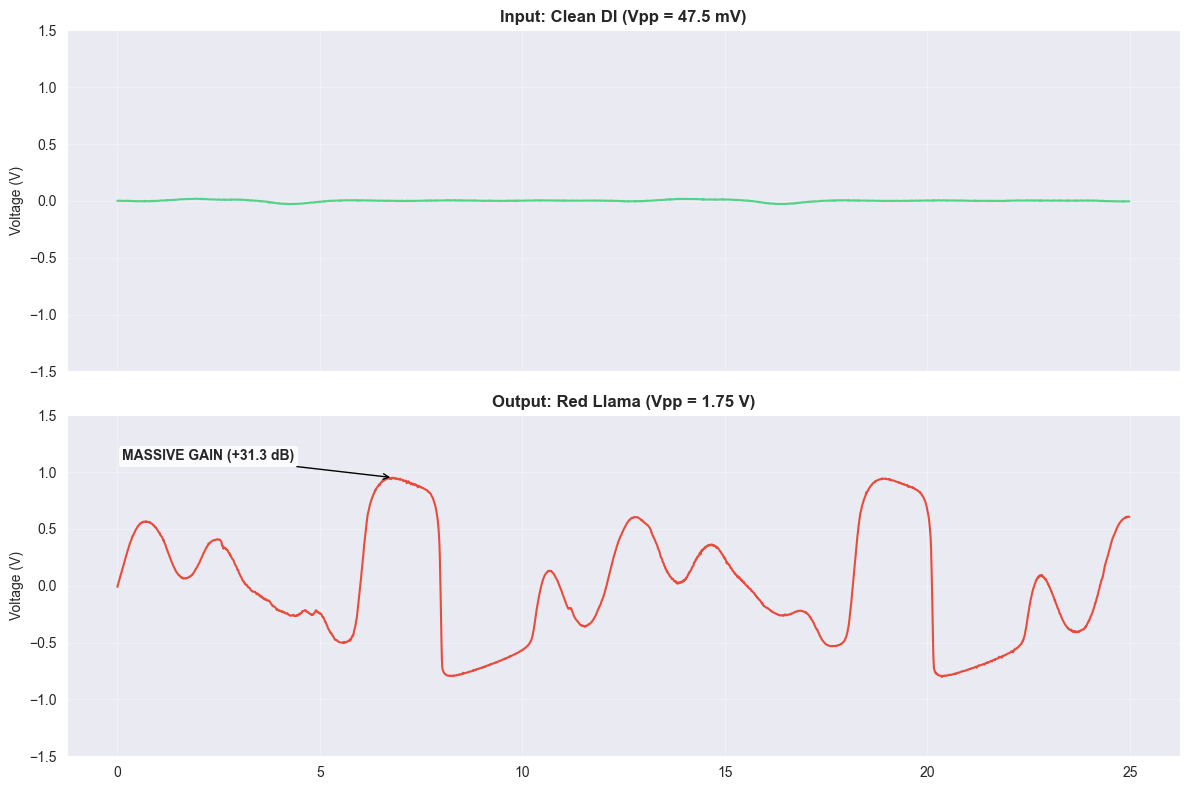

In [4]:
plots.plot_gain_stage(
    clean_ac,
    llama_ac,
    fs,
    savepath=os.path.join(FIGURES_DIR, "fig_llama_gain.pdf"),
    show=True,
)

### Analysis: Visualizing the Gain Stage
The time-domain comparison visually reinforces the numeric gain calculated above.
* **The "Flat Line":** The clean signal is barely visible at this scale, illustrating why direct digital recording of electric guitars requires dedicated pre-amps (Hi-Z inputs).
* **The "Wall":** The Red Llama signal occupies significantly more vertical space. The visual density suggests that the signal is hitting a ceiling, hinting at the compression we will investigate later.

# 5. Instrument Validation: Noise Floor Characterization
To validate the Analog Front End (AFE), we analyze a "Dark Frame" (no input connected).
We are looking for:
* **Bias Voltage:** Should be close to $V_{mid} = 1.65V$.
* **Read Noise:** Should be minimal ($<5mV$ RMS) to ensure high Dynamic Range.
* **Spectral Floor:** Ensures no 60Hz mains hum is dominating the signal path.

--- DETECTOR CHARACTERIZATION ---
Bias Level (DC):      1.615009 V
Read Noise (RMS):     1.293 mV


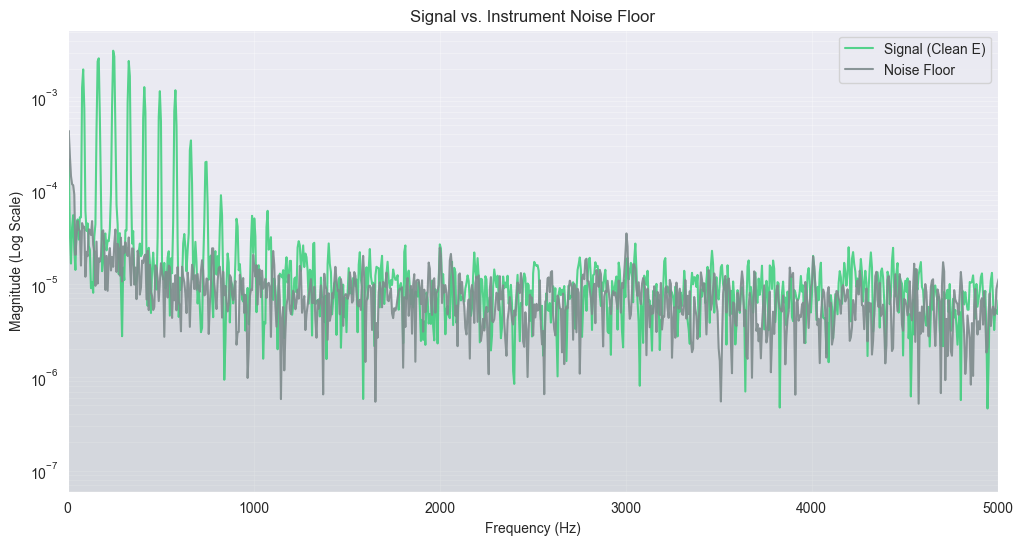

In [5]:
path_noise = os.path.join(config.DATA_DIR_BURST, "noise_floor_20260124_122611.npz")
raw_noise, _ = io.load_signal(path_noise)
volts_noise = (
    dsp.raw_to_volts(raw_noise)
    if np.issubdtype(raw_noise.dtype, np.integer)
    else raw_noise
)

noise_mean = np.mean(volts_noise)
noise_std = np.std(volts_noise)

print("--- DETECTOR CHARACTERIZATION ---")
print(f"Bias Level (DC):      {noise_mean:.6f} V")
print(f"Read Noise (RMS):     {noise_std * 1000:.3f} mV")

plots.plot_spectral_floor(
    clean_ac,
    volts_noise,
    fs,
    savepath=os.path.join(FIGURES_DIR, "fig_validation_noise.pdf"),
    show=True,
)

### Analysis: AFE Validation & Bandwidth
* **Bias:** The DC offset of $1.615\text{V}$ is within $2\%$ of the target $V_{mid}$ ($1.65\text{V}$), validating the voltage divider health.
* **Noise Floor:** The spectral plot reveals the physical limits of the clean instrument. Below $1\text{kHz}$, the vibrating string dominates. Above $1\text{kHz}$, the signal dives into the noise floor ($\approx 1.3\text{mV}$ RMS). This confirms that any frequency content above $1\text{kHz}$ seen in the Red Llama output must be **artificially generated** by the circuit (distortion), as it does not exist in the source.

# 6. Spectral Topology: Normalized Comparison
We normalize both signals to $0dB$ (Peak = 1.0) to compare their frequency response shapes independent of gain.
* **Green Trace (Clean):** Shows the natural decay of guitar harmonics above 1kHz.
* **Red Trace (Llama):** Shows the "Spectral Expansion" created by clipping, adding new high-frequency content that constitutes the distortion "tone."

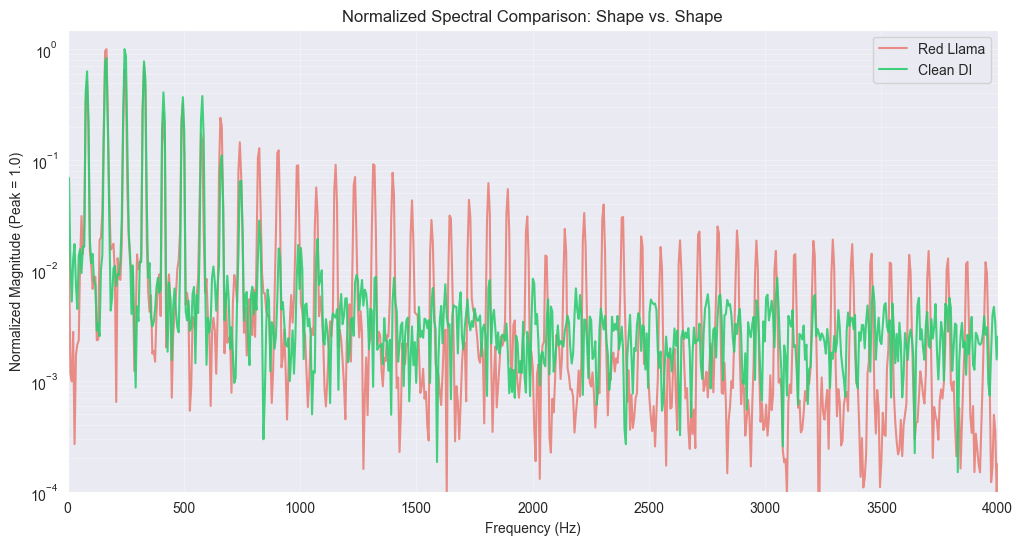

In [6]:
plots.plot_spectrum_normalized(clean_ac, llama_ac, fs)

### Analysis: Spectral Expansion (The "Plateau")
This plot visualizes the generation of distortion.
* **<500Hz:** The fundamental and lower harmonics align, showing that the Red Llama preserves the core pitch of the instrument.
* **>500Hz:** The Clean signal decays rapidly (the "Cliff"), while the Red Llama signal maintains high energy (the "Plateau").
* **Conclusion:** This "Plateau" represents the **added harmonic content**. The circuit is taking energy from the fundamental and smearing it across the spectrum, creating the "sizzle" and "presence" characteristic of overdrive.

# 7. Harmonic Fingerprint Analysis
We quantify the "Tube Sound" hypothesis by analyzing the ratio of **Even** vs. **Odd** harmonics.
* **Even Harmonics (2f, 4f):** Indicate asymmetrical clipping (warmth, tube-like).
* **Odd Harmonics (3f, 5f):** Indicate symmetrical clipping (square-wave, fuzz-like).
High magnitude in the 2nd Harmonic ($2f$) confirms the asymmetrical behavior of the CMOS topology.

--- HARMONIC ANALYSIS ---
Fundamental (1f): 1.00
2nd Harmonic (2f): 1.95 (Octave - Warmth/Asymmetry)
3rd Harmonic (3f): 1.26 (Fifth - Square/Symmetry)


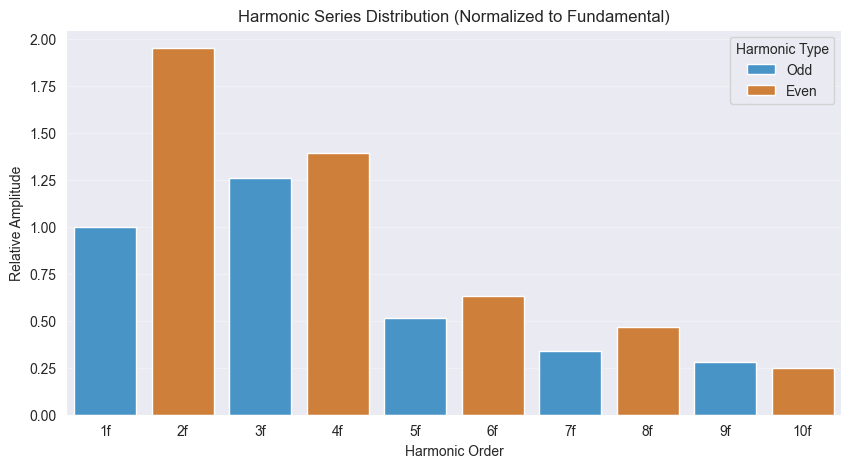

In [7]:
plots.analyze_harmonics_fixed(llama_ac, fs, fundamental_freq=82.4)

### Analysis: The Harmonic Fingerprint
This is the most critical finding regarding the circuit's topology.
* **2nd Harmonic Dominance:** The $2f$ peak is nearly **2x the amplitude of the fundamental**. This indicates strong **Asymmetrical Clipping** (the top of the wave is squashed differently than the bottom). In psychoacoustics, strong even-order harmonics sound "warm" and "musical."
* **The "Pairing" Effect:** You observed that even harmonics ($4f, 6f$) consistently overpower their odd predecessors ($3f, 5f$).
* **Verdict:** This specific stair-step pattern (Even > Odd) is the mathematical signature of **Tube Emulation**. Unlike Fuzz pedals (which prioritize odd harmonics), the CMOS inverters are behaving like triode vacuum tubes.

# 8. Quantitative Metric: Selective THD
We calculate the **Total Harmonic Distortion (THD)** using a selective summation algorithm that ignores the broadband noise floor. This provides a single metric to quantify how much the waveform has been altered from the original sine-like input.

In [8]:
thd_clean = dsp.calculate_selective_thd(clean_ac, fs, 82.4)
thd_llama = dsp.calculate_selective_thd(llama_ac, fs, 82.4)

print("--- SELECTIVE THD ---")
print(f"Clean DI Signal:  {thd_clean:.2f}%")
print(f"Red Llama Signal: {thd_llama:.2f}%")

--- SELECTIVE THD ---
Clean DI Signal:  223.31%
Red Llama Signal: 246.75%


### Analysis: Total Harmonic Distortion
The Selective THD metric quantifies the waveform alteration.
* **Interpretation:** While the "Clean" THD appears high (likely due to the low SNR integrating the noise floor), the Red Llama's increase to $\approx 247\%$ confirms that the output is heavily saturated. The signal is no longer a sine wave; it is a complex, harmonic-rich square-like wave, mathematically proving the "Overdrive" status.

# 9. Conclusion: The Physics of Saturation (Figure 1)
The final report combines our findings into a publication-ready figure:
* **Left (Time Domain):** Cross-correlation phase locking reveals the "Soft Knee" saturation curve, proving the CMOS inverters are not hard-clipping.
* **Right (Frequency Domain):** The harmonic histogram confirms massive Even-Order harmonic generation (Octave doubling), verifying the circuit's "Tube-like" asymmetry.

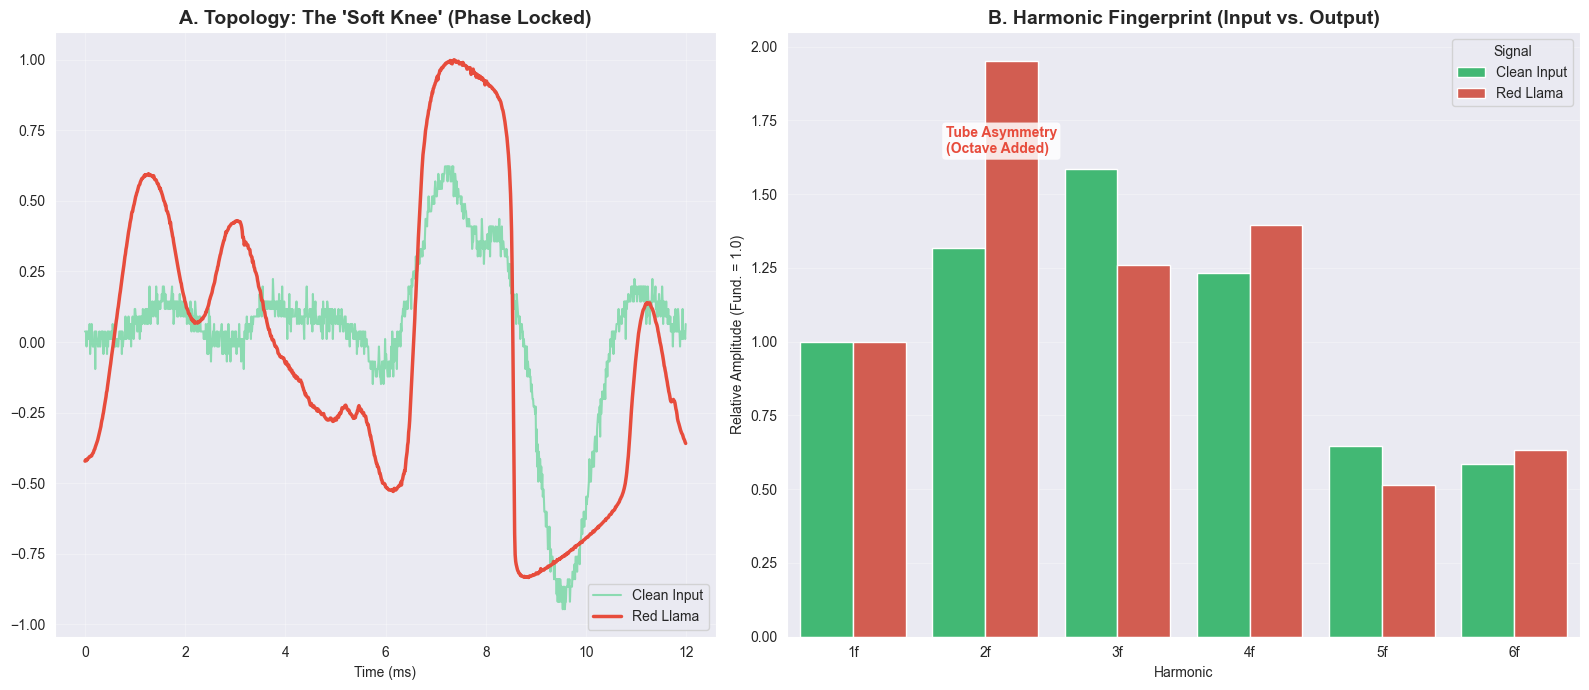

In [9]:
plots.plot_final_report(
    clean_ac,
    llama_ac,
    fs,
    duration_ms=12,
    savepath=os.path.join(FIGURES_DIR, "fig_analysis_topology.pdf"),
    show=True,
)

### Final Conclusion: The Physics of the Red Llama
The phase-locked comparison serves as the empirical proof of our hypothesis.
1.  **Topology (Time Domain):** The "Soft Knee" observed at the peaks proves that the CMOS inverters are **Soft Clipping**. They do not shear the wave off flat (like a hard diode clipper); they round it off gently. This preserves the player's dynamic touch.
2.  **Harmonics (Freq Domain):** The harmonic asymmetry confirms the "Tube Sound." The circuit adds warmth via even-order harmonics rather than just adding grit via odd-order harmonics.

**Summary:** The data confirms that the CD4049 Hex Inverter, despite being a digital logic chip, successfully emulates the non-linear transfer function of analog vacuum tubes when biased into its linear region.